# "Island" catchment areas

Ordinarily the catchment areas of each stroke unit don't match up nicely to other defined regions, for example the Integrated Care Boards or Ambulance Service boundaries.

Sometimes though it's preferable to only consider patients within a given region, even if patients outside the border would still ordinarily travel to a stroke unit within that region.

This is like pretending that everything outside the region doesn't exist. Outside the region, there are no LSOA with patients who will want to enter the region for treatment. Outside the region, there are no other stroke units that patients within the region might prefer to travel to. When the regions are split off like this, it is as though each one is its own island with nothing else surrounding it.

To create this effect with the catchment code, it is possible to restrict:
+ which stroke units are considered for each LSOA
+ which LSOA are considered

In this example we will restrict everything to the ISDN named "West Midlands".


## Notebook setup

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo

import pandas as pd
import matplotlib.pyplot as plt
from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

## Load data

__LSOA travel time__

This dataframe contains one row for each LSOA in England and Wales. There is one column for each stroke unit in England and Wales. The value in each cell is the time from that row's LSOA to that column's stroke unit.

In [2]:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()

# Show the first five rows and columns:
df_travel_lsoa.iloc[:5, :5]

,B152TH,B714HJ,B95SS,BA13NG,BA214AT
LSOA,,,,,
Adur 001A,173.3,179.8,171.2,161.5,152.9
Adur 001B,173.3,179.8,172.3,161.5,152.9
Adur 001C,173.3,180.9,172.3,150.8,151.9
Adur 001D,173.3,180.9,172.3,161.5,152.9
Adur 001E,174.4,180.9,173.3,150.8,151.9


__Stroke unit services__

This dataframe contains information on which stroke units provide which services (IVT and MT). The imported dataframe, df_units, contains only units that appear in the travel time matrix. This includes units that are not acute stroke units (i.e. provide neither thrombolysis nor thrombectomy).

In [3]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

df_units.head(3).T

postcode,SY231ER,CB20QQ,L97AL
stroke_team,Bronglais Hospital (Aberystwyth),"Addenbrooke's Hospital, Cambridge","University Hospital Aintree, Liverpool"
short_code,AB,AD,AI
ssnap_name,Bronglais Hospital,Addenbrooke's Hospital,University Hospital Aintree
use_ivt,1,1,1
use_mt,0,1,1
use_msu,0,1,1
transfer_unit_postcode,nearest,nearest,nearest
lsoa,Ceredigion 002A,Cambridge 013D,Liverpool 005A
lsoa_code,W01000512,E01017995,E01006654
region,Hywel Dda University Health Board,NHS Cambridgeshire and Peterborough ICB - 06H,NHS Cheshire and Merseyside ICB - 99A


__LSOA boundaries__

In [4]:
gdf_lsoa = stroke_maps.load_data.lsoa_geography()

gdf_lsoa.head(3)

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.09706,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((-0.09474 51.52060, -0.09546 51.51544..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.09197,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((-0.08810 51.51941, -0.09546 51.51544..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.09523,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((-0.09453 51.52205, -0.09274 51.52139..."


__ISDN boundaries__

In [5]:
gdf_isdn = stroke_maps.load_data.isdn_geography()

# Only keep the chosen region:
gdf_isdn = gdf_isdn[gdf_isdn['isdn'] == 'West Midlands']

gdf_isdn.head(3)

,isdn,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry
18,West Midlands,E38000236,NHS Herefordshire and Worcestershire ICB - 18C,364519,249269,-2.51986,52.14057,82,cb92b6e6-7380-4183-863b-835220205fc0,"POLYGON ((388888.001 281369.374, 390847.000 28..."


__Stroke unit coordinates__

Load in the stroke unit coordinates and merge in the services information:

In [6]:
gdf_units = stroke_maps.load_data.stroke_unit_coordinates()
gdf_units = pd.merge(
    gdf_units, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

__Colour list__

For the plots.

In [7]:
# Make a list of colour names:
# Expecting to only need about six colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

Functions to make both sets of maps:

In [8]:
def make_gdf(df_catchment_acute, gdf_lsoa):
    gdf_lsoa_acute = gdf_lsoa.copy()
    
    # Merge in the information on nearest acute stroke unit:
    gdf_lsoa_acute = pd.merge(
        gdf_lsoa_acute, df_catchment_acute['unit_postcode'],
        left_on='LSOA11NM', right_index=True, how='right'
    )
    # Combine LSOA with the same acute stroke unit into a single region:
    gdf_catchment_acute = stroke_maps.geo.combine_regions(gdf_lsoa_acute, 'unit_postcode')
    # Convert the coordinates to British National Grid so that they match other geometry:
    gdf_catchment_acute = gdf_catchment_acute.to_crs('EPSG:27700')
    # Assign colours:
    gdf_catchment_acute['adjacent_colours'] = greedy(
        gdf_catchment_acute, min_distance=1, balance='count').astype(str)
    # Assign these colours to the regions:
    gdf_catchment_acute['colour_str'] = gdf_catchment_acute['adjacent_colours'].map(colour_map)

    return gdf_catchment_acute

In [39]:
def plot_catchment(
        gdf_catchment_acute,
        title='',
        bounds=[]
    ):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Catchment areas:
    gdf_catchment_acute.plot(
        ax=ax,              # Set which axes to use for plot
        antialiased=False,  # Avoids artefact boundary lines
        color=gdf_catchment_acute['colour_str'],  # set colours using this column
        linewidth=0.2,
        )
    
    # Setup for ISDN:
    kwargs_isdn = dict(
        facecolor='none',
        edgecolor='k',
        linewidth=0.2,
    )
    # ISDN outlines:
    gdf_isdn.plot(
        ax=ax,              # Set which axes to use for plot
        antialiased=False,  # Avoids artefact boundary lines
        **kwargs_isdn
        )
    # Can't put regions like this ^ in the legend, so fake it now.
    # Draw an area so small you'll never see it
    # and give it the same properties as the wanted region.
    points = [p for p in gdf_isdn['geometry'].iloc[0].exterior.coords]
    x = points[0][0]
    y = points[0][1]
    ax.fill(
        [x, x+1e-7],
        [y, y+1e-7],
        **kwargs_isdn,
        label='West Midlands ISDN'
    )
    
    # Pick out which stroke units to plot:
    mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
    mask_mt = (gdf_units['use_mt'] == 1)
    
    # IVT units:
    ax.scatter(
        gdf_units.loc[mask_ivt, 'geometry'].x,
        gdf_units.loc[mask_ivt, 'geometry'].y,
        marker='o',
        facecolor='k',
        label='IVT unit',
        s=20,  # size
        )
    
    # MT units:
    ax.scatter(
        gdf_units.loc[mask_mt, 'geometry'].x,
        gdf_units.loc[mask_mt, 'geometry'].y,
        marker='*',
        facecolor='k',
        label='MT unit',
        s=40,  # size
        )

    # Axis limits:
    if len(bounds) > 0:
        ax.set_xlim(bounds[0], bounds[2])
        ax.set_ylim(bounds[1], bounds[3])

    # Remove the axis border, ticks, labels...
    ax.axis('off')
    ax.set_title(title)
    
    # Add legend:
    ax.legend()
    
    plt.show()

## Method 1: nearest stroke unit

First we'll create a map of the normal stroke unit catchment areas in the West Midlands when we don't restrict anything.

Find a list of stroke units that offer acute care. These are units where `use_ivt` and/or `use_mt` are equal to 1 (one).

In [10]:
mask_acute = ((df_units['use_ivt'] == 1) | (df_units['use_mt'] == 1))

postcodes_acute_units = df_units[mask_acute].index.values

Now make a copy of the travel time matrix that only includes times to these units:

In [11]:
df_travel_lsoa_acute = df_travel_lsoa[postcodes_acute_units].copy()

Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [12]:
df_catchment_acute = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa_acute)

Limit this results dataframe to only stroke units in the chosen region:

In [13]:
mask_here = (df_units['isdn'] == 'West Midlands')
postcodes_here = df_units[mask_here].index.values

In [14]:
mask_catchment = df_catchment_acute['unit_postcode'].isin(postcodes_here)
df_catchment_acute = df_catchment_acute[mask_catchment]

Create the map. Same setup as the previous LSOA catchment documentation. __TO DO: add link__

In [15]:
gdf_catchment_acute = make_gdf(df_catchment_acute, gdf_lsoa)

Plot the unit locations and catchment areas using matplotlib:

## Method 2: Island

Make a copy of the travel time matrix to edit:

In [17]:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()

df_travel_lsoa_here = df_travel_lsoa.copy()

Limit the stroke units:

In [18]:
mask_units = (
    (df_units['isdn'] == 'West Midlands') &
    (df_units['use_ivt'] == 1)
)

df_units_here = df_units[mask_units]

In [19]:
df_travel_lsoa_here = df_travel_lsoa_here[df_units_here.index]

Load the LSOA-region lookup data:

In [20]:
df_lsoa_regions = stroke_maps.load_data.lsoa_region_lookup()
df_regions = stroke_maps.load_data.region_lookup()

# Merge the ISDN names into the LSOA-region lookup:
df_lsoa_regions = pd.merge(
    df_lsoa_regions.reset_index(),
    df_regions.reset_index()[['region_code', 'isdn']],
    on='region_code', how='left'
)

Pick out the LSOAs in the chosen region:

In [21]:
mask_lsoa = df_lsoa_regions['isdn'] == 'West Midlands'
df_lsoa_regions = df_lsoa_regions[mask_lsoa].copy()

Limit the travel time matrix to only these LSOA:

In [22]:
mask_travel = df_travel_lsoa_here.index.isin(df_lsoa_regions['lsoa'])
df_travel_lsoa_here = df_travel_lsoa_here[mask_travel]

Resulting travel matrix:

In [23]:
df_travel_lsoa_here

,CV22DX,HR12ER,B152TH,WR51DD
LSOA,,,,
Birmingham 001A,36.9,84.2,31.6,47.7
Birmingham 001B,36.9,85.3,33.7,49.8
Birmingham 001C,38.0,84.2,32.6,48.8
Birmingham 001D,36.9,85.3,33.7,49.8
Birmingham 002A,35.9,85.3,33.7,49.8
...,...,...,...,...
Wyre Forest 013D,64.9,57.4,38.0,26.2
Wyre Forest 014A,64.9,52.0,38.0,26.2
Wyre Forest 014B,65.9,52.0,39.1,27.3


Pull out the nearest stroke units:

In [24]:
df_catchment_island = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa_here)

df_catchment_island

,unit_travel_time,unit_postcode
LSOA,,
Birmingham 001A,31.6,B152TH
Birmingham 001B,33.7,B152TH
Birmingham 001C,32.6,B152TH
Birmingham 001D,33.7,B152TH
Birmingham 002A,33.7,B152TH
...,...,...
Wyre Forest 013D,26.2,WR51DD
Wyre Forest 014A,26.2,WR51DD
Wyre Forest 014B,27.3,WR51DD


This dataframe contains only stroke units and LSOA within the boundary of the selected region.

Create the map. Same setup as the previous LSOA catchment documentation. __TO DO: add link__

In [25]:
gdf_catchment_island = make_gdf(df_catchment_island, gdf_lsoa)

## Plots

Find shared axis limits by finding the bounding box that just contains both sets of catchment areas:

In [33]:
bounds_acute = gdf_catchment_acute.total_bounds
bounds_island = gdf_catchment_island.total_bounds

bounds = [
    min(bounds_acute[0], bounds_island[0]),
    min(bounds_acute[1], bounds_island[1]),
    max(bounds_acute[2], bounds_island[2]),
    max(bounds_acute[3], bounds_island[3]),
]

Plot the unit locations and catchment areas using matplotlib:

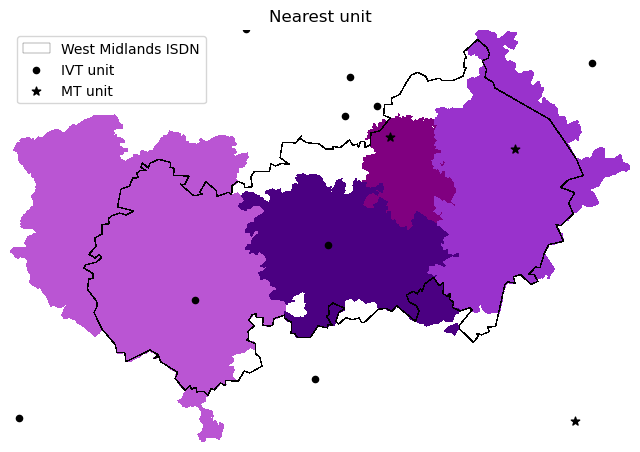

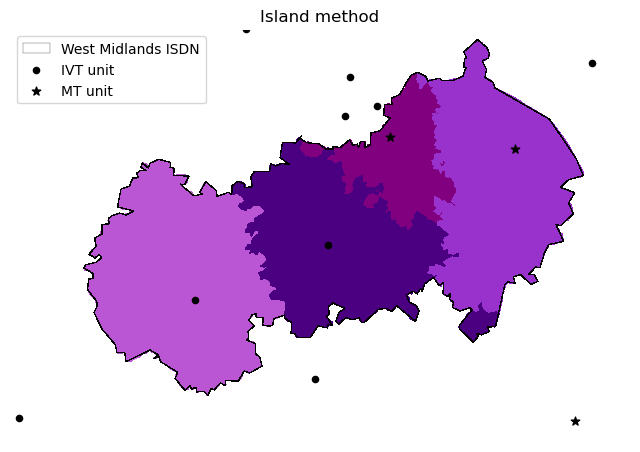

In [40]:
plot_catchment(gdf_catchment_acute, title='Nearest unit', bounds=bounds)
plot_catchment(gdf_catchment_island, title='Island method', bounds=bounds)